In [294]:
import json
import numpy as np
import pandas as pd
from typing import Dict
import matplotlib.pyplot as plt

plt.style.use("bmh")

In [295]:
features_dict = {
    "stfmjob":  "How satisfied are you in your main job",
    "trdawrk":  "Too tired after work to enjoy things like doing at home, how often",
    "jbprtfp":  "Job prevents you from giving time to partner/family, how often",
    "pfmfdjba": "Partner/family fed up with pressure of your job, how often",
    "dcsfwrka": "Current job: can decide time start/finish work",
    "wrkhome":  "Work from home or place of choice, how often",
    "wrklong":  "Employees expected to work overtime, how often",
    "wrkresp":  "Employees expected to be responsive outside working hours, how often",
    "health":   "Subjective general health",
    "stfeco":   "How satisfied with present state of economy in country",
    "hhmmb":    "Number of people living regularly as member of household",
    "hincfel":  "Feeling about household's income nowadays",
    "trstplc":  "Trust in the police",
    "sclmeet":  "How often socially meet with friends, relatives or colleagues",
    "hlthhmp":  "Hampered in daily activities by illness/disability/infirmity/mental problem",
    "sclact":   "Take part in social activities compared to others of same age",
    "iphlppl":  "Important to help people and care for others well-being",
    "ipsuces":  "Important to be successful and that people recognise achievements",
    "ipstrgv":  "Important that government is strong and ensures safety",
    "happy":    "Happiness"
}

In [296]:
data = pd.read_csv(
    "/home/mehrshad/code/arthurcornelio88/how-happy"
    +"-in-europe/data/20240319_ESS10_manually-filtered_arthurcornelio88.csv"
).reset_index(drop=True)
data = data.drop("Unnamed: 0", axis=1)
data = data[~data["happy"].isin([77, 88, 99])]

with open("../data/features_table.json", 'r') as file:
    features_tables = json.load(file)

/tmp/ipykernel_12581/66283325.py:1: DtypeWarning: Columns (82,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


In [297]:
def json_to_df(features_json: Dict, feature: str):
    feature_dict = features_json[feature]
    df = pd.DataFrame.from_dict(
        feature_dict,
        columns=["val"],
        orient="index").reset_index()
    df.columns = [feature+"_key", feature+"_desc"]
    df[feature+"_key"] = df[feature+"_key"].astype(int)
    df[feature+"_desc"] = df[feature+"_desc"].astype(str)
    return df

def enrich_df(df: pd.DataFrame, enrichment_df: pd.DataFrame):
    feature = enrichment_df.columns[0].replace("_key", "")
    return df.merge(
        enrichment_df,
        how="left",
        left_on=feature,
        right_on=feature+"_key"
    ).drop(feature+"_key", axis=1)

def remove_star_vals(df: pd.DataFrame, feature: str):
    mask = df[feature+"_desc"] == "*"
    print(f"{feature} %rows: " + str(len(df[mask]) / len(df) * 100))
    return df[~mask]

In [298]:
def create_map(arr: np.ndarray):
    aux_vals = np.arange(1, arr[-1] // 2 + 1)
    if len(arr)%2 == 0:
        aux_vals = np.concatenate([-np.flip(aux_vals), aux_vals])
    else:
        aux_vals = np.concatenate([-np.flip(aux_vals), np.array([0.5]), aux_vals])
    dict_map = {}
    for ind, el in enumerate(arr):
        dict_map[el] = aux_vals[ind]
    return dict_map

In [299]:
aux_data = data[features_dict.keys()].copy()
for feature in features_dict.keys():
    if feature == "wrklong":
        aux_data.loc[aux_data[feature] == 55, feature] = 66
    aux_df = json_to_df(features_tables, feature)
    aux_data = enrich_df(aux_data, aux_df)
    aux_data = remove_star_vals(aux_data, feature)

    mask = aux_data[feature+"_desc"] == "-1"
    vals = np.sort(aux_data[~mask][feature].unique())
    if 0 in vals:
        aux_data.loc[~mask, feature] += 1
        vals += 1
    map_dict = create_map(vals)
    aux_data[feature] = aux_data[feature].replace(map_dict)
    aux_data.loc[mask, feature] = 0
    if 0.5 in map_dict.values():
        indices = aux_data[aux_data[feature] == 0.5].index.to_list()
        indices = np.random.choice(indices, len(indices)//2)
        aux_data.loc[aux_data.index.isin(indices), feature] = -0.5

stfmjob %rows: 0.8155432957543776
trdawrk %rows: 0.29557973935241166
jbprtfp %rows: 0.3234065489826169
pfmfdjba %rows: 0.8354738407462484
dcsfwrka %rows: 0.41171338204820596
wrkhome %rows: 0.2573579739904175
wrklong %rows: 1.2187422799264362
wrkresp %rows: 0.6696862755995221
health %rows: 0.0755329267610362
stfeco %rows: 1.9009490747221365
hhmmb %rows: 0.2711187214611872
hincfel %rows: 0.9357561882958936
trstplc %rows: 0.43907793633369924
sclmeet %rows: 0.2727325480183369
hlthhmp %rows: 0.25893168858373095
sclact %rows: 1.2134293964938891
iphlppl %rows: 0.6850326276316178
ipsuces %rows: 0.4846142411178832
ipstrgv %rows: 0.6184273422562141
happy %rows: 0.0


In [300]:
print(r"Percentage of total data: %{:.2f}".format(len(aux_data) / len(data) * 100))

Percentage of total data: %88.66


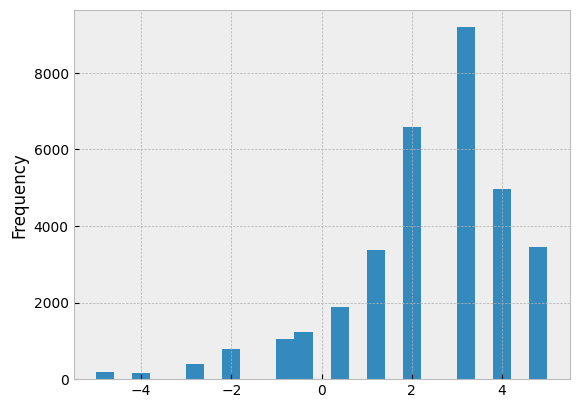

In [301]:
aux_data["happy"].plot.hist(bins=25);

In [302]:
# happy_map_dict = {0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 3}
# aux_data["happy"] = aux_data["happy"].replace(happy_map_dict)

<Axes: xlabel='happy', ylabel='Count'>

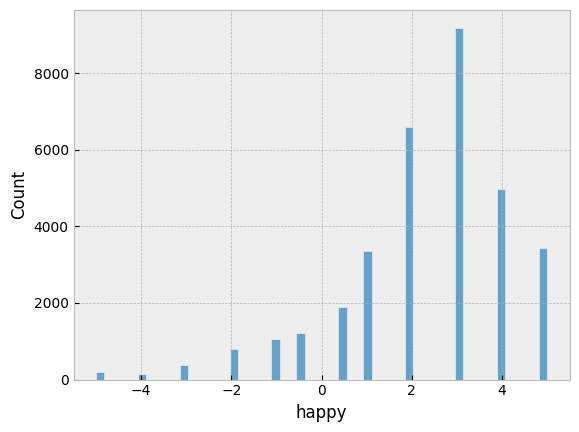

In [303]:
sns.histplot(aux_data["happy"])

In [305]:
# unhappy_df = aux_data[aux_data["happy"] == 1]
# n = len(unhappy_df)
#
# inds = np.random.choice(aux_data[aux_data["happy"] == 2].index, size=n)
# middle_happy_df = aux_data[aux_data.index.isin(inds)]
#
# inds = np.random.choice(aux_data[aux_data["happy"] == 3].index, size=n)
# extremely_happy_df = aux_data[aux_data.index.isin(inds)]
#
# ml_df = pd.concat([unhappy_df, middle_happy_df, extremely_happy_df]).reset_index(drop=True)

In [306]:
# sns.histplot(ml_df["happy"])

In [307]:
from sklearn.preprocessing import MinMaxScaler
minmax_X = MinMaxScaler()
minmax_Y = MinMaxScaler()
cols = [col for col in aux_data.columns if "_desc" not in col and "happy" not in col]
X = minmax_X.fit_transform(aux_data[cols])
y = minmax_Y.fit_transform(aux_data["happy"].values[:, np.newaxis])

In [308]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [309]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=7,
    eta=0.1,
    subsample=0.7,
    colsample_bytree=0.8
)

# Fit the classifier to the training data
model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 0.029305603801514434


In [310]:
yy_pred = minmax_Y.inverse_transform(y_pred[:, np.newaxis])
yy_test = minmax_Y.inverse_transform(y_test)

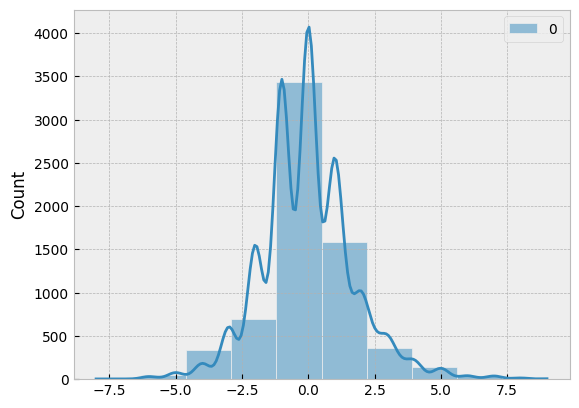

In [311]:
import seaborn as sns
sns.histplot(np.round(yy_pred) - yy_test, kde=True, bins=10);

<Axes: >

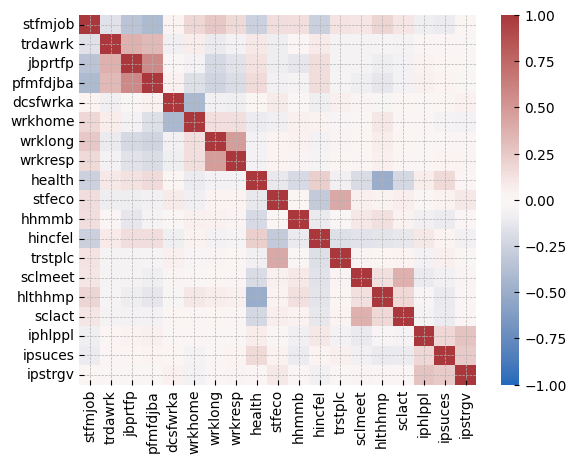

In [313]:
corr_matrix = aux_data[list(features_dict.keys())[:-1]].corr()
sns.heatmap(corr_matrix, vmax=1.0, vmin=-1.0, cmap="vlag")

In [224]:
features_dict

{'stfmjob': 'How satisfied are you in your main job',
 'trdawrk': 'Too tired after work to enjoy things like doing at home, how often',
 'jbprtfp': 'Job prevents you from giving time to partner/family, how often',
 'pfmfdjba': 'Partner/family fed up with pressure of your job, how often',
 'dcsfwrka': 'Current job: can decide time start/finish work',
 'wrkhome': 'Work from home or place of choice, how often',
 'wrklong': 'Employees expected to work overtime, how often',
 'wrkresp': 'Employees expected to be responsive outside working hours, how often',
 'health': 'Subjective general health',
 'stfeco': 'How satisfied with present state of economy in country',
 'hhmmb': 'Number of people living regularly as member of household',
 'hincfel': "Feeling about household's income nowadays",
 'trstplc': 'Trust in the police',
 'sclmeet': 'How often socially meet with friends, relatives or colleagues',
 'hlthhmp': 'Hampered in daily activities by illness/disability/infirmity/mental problem',
 's

In [ ]:
%s/^[A-Z].*//g
%s/\(\d\) \t/\1: "/g
%s/^\*.*//g
%s/Not applicable\*/-1/g
%s/".*/\0",/g
%s/".*\*/"\*/g
%s/^[a-z].*/}, "\0": {/g
%s/^\n//g
%s/,$\n}/}/g
%s/^\(\d\+\)/"\1"/g